# Tech Challenge — Previsão de Obesidade

 **Notebook Fase 4 do Tech Challenge (FIAP).**


Este projeto tem como objetivo desenvolver um modelo de Machine Learning capaz de prever o nível de obesidade de um indivíduo com base em dados demográficos, hábitos alimentares, estilo de vida e atividade física.

A solução foi pensada como uma ferramenta de **apoio à decisão clínica**, auxiliando profissionais de saúde na identificação precoce de riscos associados à obesidade.


E tem como Objetivos tecnico: pipeline reprodutível, EDA aprofundada, comparativo de modelos, explicabilidade, deploy com Streamlit.

##0. Setup (instalação de dependências)


In [1]:
# Execute no Colab ou ambiente local
!pip install -q scikit-learn pandas numpy matplotlib seaborn xgboost joblib imbalanced-learn streamlit shap

 ##1. Imports e constantes

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from preprocessing import DropCols, ImcCalculator, safe_onehot_encoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import shap
from imblearn.over_sampling import SMOTE
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [3]:
RUN_FULL_TRAINING = False
RANDOM_STATE = 42
DATA_PATH = 'https://raw.githubusercontent.com/LaisStefanieDiasPereira/postech-data-analytics/main/FIAP/FASE%204/Tech_Challenge_4/data_base/Obesity.csv'
df = pd.read_csv(DATA_PATH)

## 2. Leitura dos dados e inspeção inicial

In [4]:
# carregar
df = pd.read_csv(DATA_PATH)
# primeiras linhas
print('Shape:', df.shape)
df.head()

Shape: (2111, 17)


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# informações e estatísticas
df.info()
# estatísticas descritivas
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,2111,2,Male,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2111.0,NaN,NaN,NaN,24.3126,6.345968,14.0,19.947192,22.77789,26.0,61.0
Height,2111.0,NaN,NaN,NaN,1.701677,0.093305,1.45,1.63,1.700499,1.768464,1.98
Weight,2111.0,NaN,NaN,NaN,86.586058,26.191172,39.0,65.473343,83.0,107.430682,173.0
family_history,2111,2,yes,1726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAVC,2111,2,yes,1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCVC,2111.0,NaN,NaN,NaN,2.419043,0.533927,1.0,2.0,2.385502,3.0,3.0
NCP,2111.0,NaN,NaN,NaN,2.685628,0.778039,1.0,2.658738,3.0,3.0,4.0
CAEC,2111,4,Sometimes,1765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SMOKE,2111,2,no,2067,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Limpeza inicial

In [6]:
# duplicados
print('Duplicados:', df.duplicated().sum())
df = df.drop_duplicates()
# Se houver missing values: política simples (documentar no PDF)
print('Missing por coluna:\n', df.isnull().sum())
if df.isnull().sum().sum() > 0:
 df = df.dropna()
print ('Shape após limpeza:', df.shape)

Duplicados: 24
Missing por coluna:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64
Shape após limpeza: (2087, 17)


## 4. Conversão e rounding conforme dicionário

In [7]:
# Lista das colunas que representam variáveis ordinais (valores em escala, ex: 1-3)
ordinal_cols = ['FCVC','NCP','FAF','CH2O','TUE']

# Para cada coluna ordinal:
for col in ordinal_cols:
    # verifica se a coluna realmente existe no DataFrame
    if col in df.columns:
        # Converte para número, arredonda e transforma em inteiro nulo-tolerante
        df[col] = pd.to_numeric(df[col], errors='coerce').round().astype('Int64')


# Converte colunas numéricas essenciais, caso estejam como texto no dataset
for c in ['Height','Weight','Age', 'FAF']:
    if c in df.columns:
        # Converte valores para número;
        df[c] = pd.to_numeric(df[c], errors='coerce')


# Se existir Height e Weight, calcula IMC (Índice de Massa Corporal)
if {'Weight','Height'}.issubset(df.columns):
    # Fórmula IMC = peso / altura²
    df['IMC'] = (df['Weight'] / (df['Height'] ** 2)).round(2)

# Procura colunas que contenham "obes" no nome:
target_candidates = [c for c in df.columns if 'obes' in c.lower()]

# Regra:
# 1. Se existir coluna literalmente chamada 'Obesity', ela é a escolhida
# 2. Senão, pega o primeiro nome que contenha 'obes'
# 3. Se nada for encontrado, target_col vira None
target_col = 'Obesity' if 'Obesity' in df.columns else (target_candidates[0] if target_candidates else None)

# Mostra qual coluna foi identificada como variável target
print('Target selected:', target_col)


# Para cada coluna categórica (object) imprime até 10 valores únicos, para especionar categorias estranhas.
for col in df.select_dtypes(include='object').columns:
    print(col, '->', df[col].unique()[:10])


Target selected: Obesity
Gender -> ['Female' 'Male']
family_history -> ['yes' 'no']
FAVC -> ['no' 'yes']
CAEC -> ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE -> ['no' 'yes']
SCC -> ['no' 'yes']
CALC -> ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS -> ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity -> ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


 ## 5. Análise Exploratória Rápida (EDA)

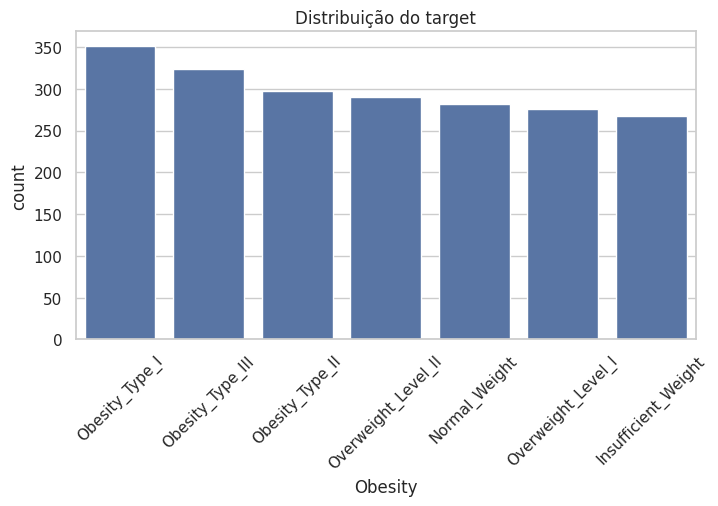

In [8]:
# Distribuição do target
plt.figure(figsize=(8,4))
sns.countplot(data=df, x=target_col, order=df[target_col].value_counts().index)
plt.title('Distribuição do target')
plt.xticks(rotation=45)
plt.show()

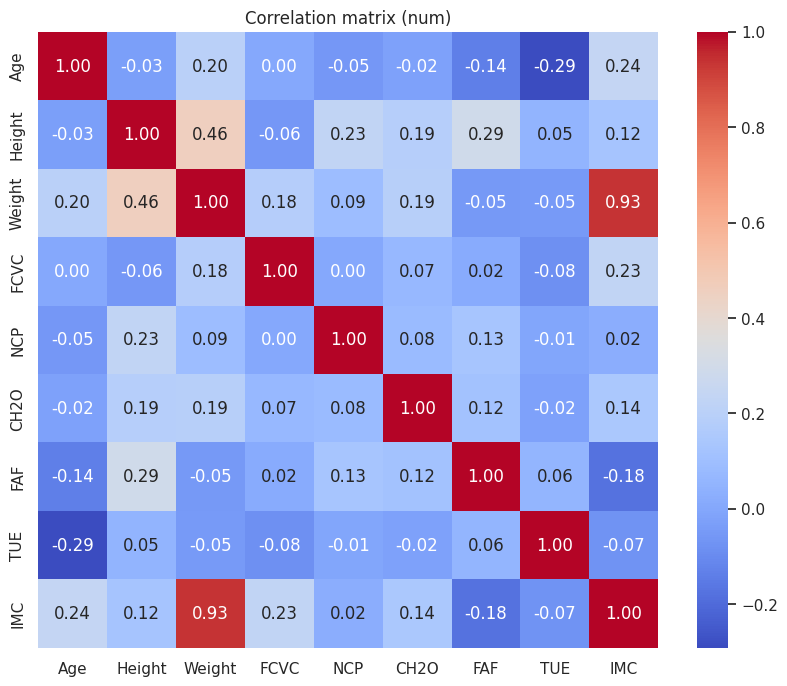

In [9]:
# heatmap correlação (numérica)
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (num)')
plt.show()

### Principais Observações da Análise Exploratória

Observa-se que variáveis comportamentais como **frequência de atividade física (FAF)** e **consumo de água (CH2O)** apresentam relação inversa com os níveis mais elevados de obesidade.

Esses padrões indicam que, além de fatores físicos, hábitos de vida desempenham papel fundamental na diferenciação entre os níveis de obesidade, reforçando a relevância do modelo para ações preventivas.


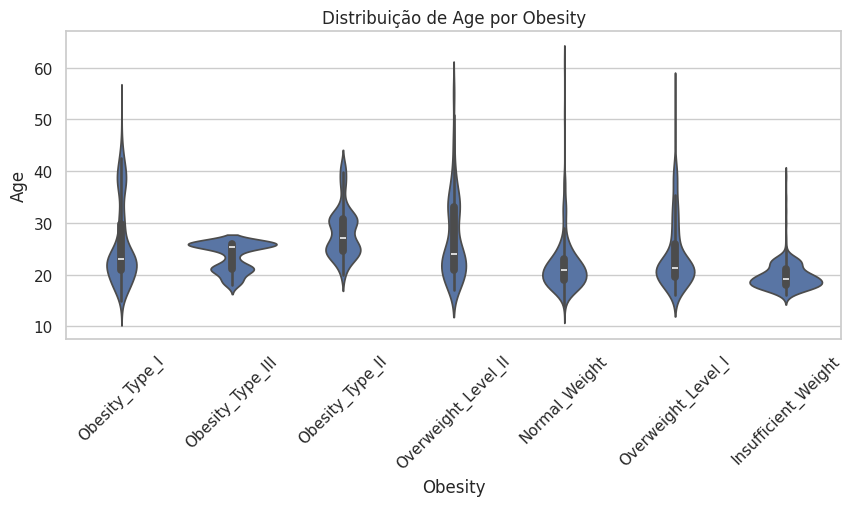

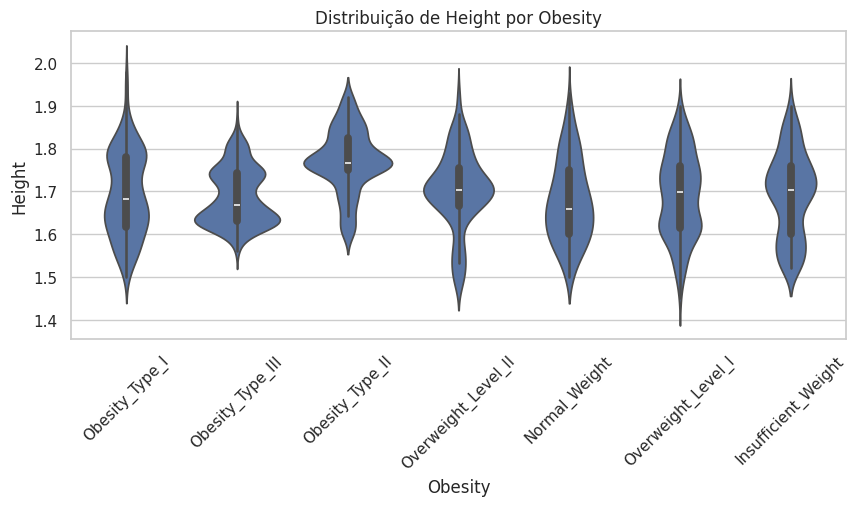

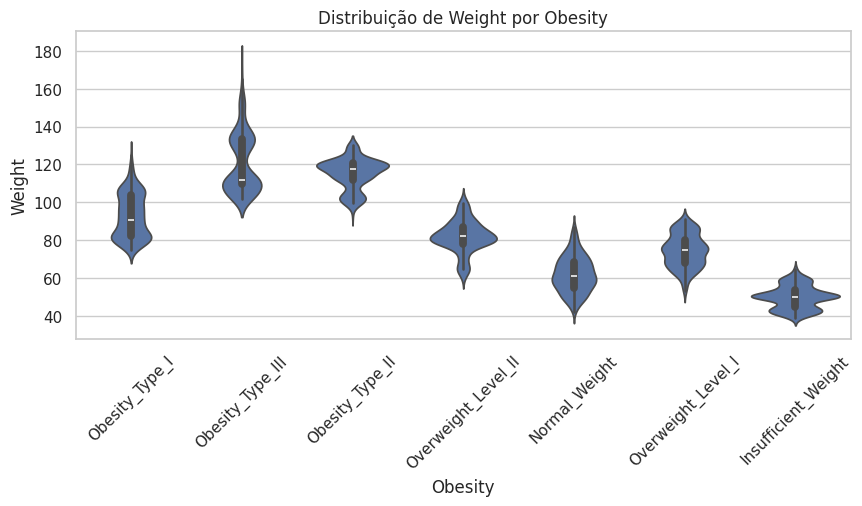

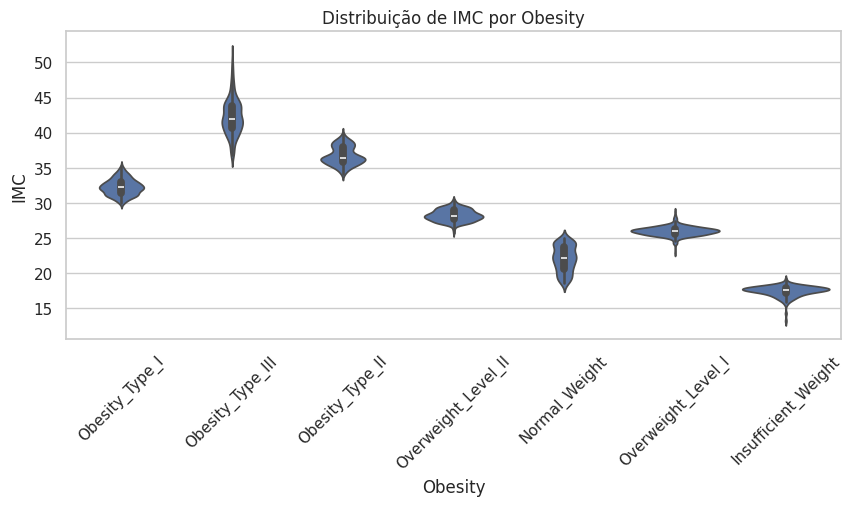

In [10]:
#Analise de violinplot
num_cols = [c for c in ['Age', 'Height', 'Weight', 'IMC'] if c in df.columns]
order = df[target_col].astype('category').value_counts().index

for c in num_cols:
    plt.figure(figsize=(10,4))
    sns.violinplot(
        data=df,
        x=target_col,
        y=c,
        order=order
    )
    plt.title(f'Distribuição de {c} por {target_col}')
    plt.xticks(rotation=45)
    plt.show()

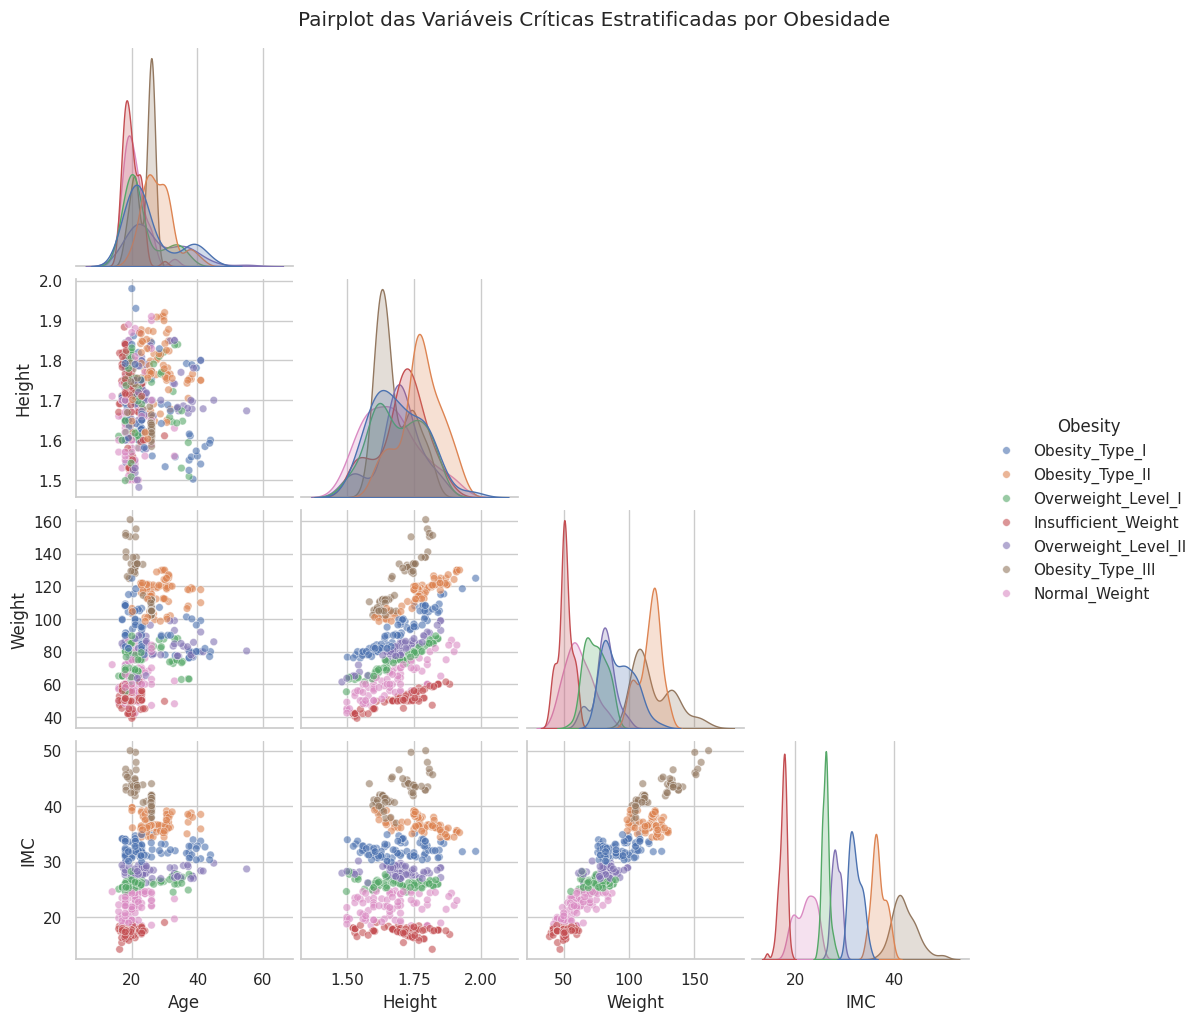

In [11]:
# Seleciona apenas colunas numéricas críticas + target
pairplot_cols = ['Age', 'Height', 'Weight', 'IMC']
pairplot_cols = [c for c in pairplot_cols if c in df.columns]

# Se o dataset for > 2000, usar amostragem para performance
sample_df = df.sample(frac=0.25, random_state=42) if len(df) > 2000 else df

# Cria o pairplot com cor baseada no target
sns.pairplot(
    sample_df[pairplot_cols + [target_col]],   # apenas as colunas necessárias
    hue=target_col,                             # cor baseada na classe de obesidade
    diag_kind='kde',                            # distribuições suaves na diagonal
    corner=True,                                # mostra metade da matriz para não poluir
    plot_kws={'alpha':0.6, 's':30}              # melhora visual dos pontos
)

plt.suptitle('Pairplot das Variáveis Críticas Estratificadas por Obesidade', y=1.02)
plt.show()

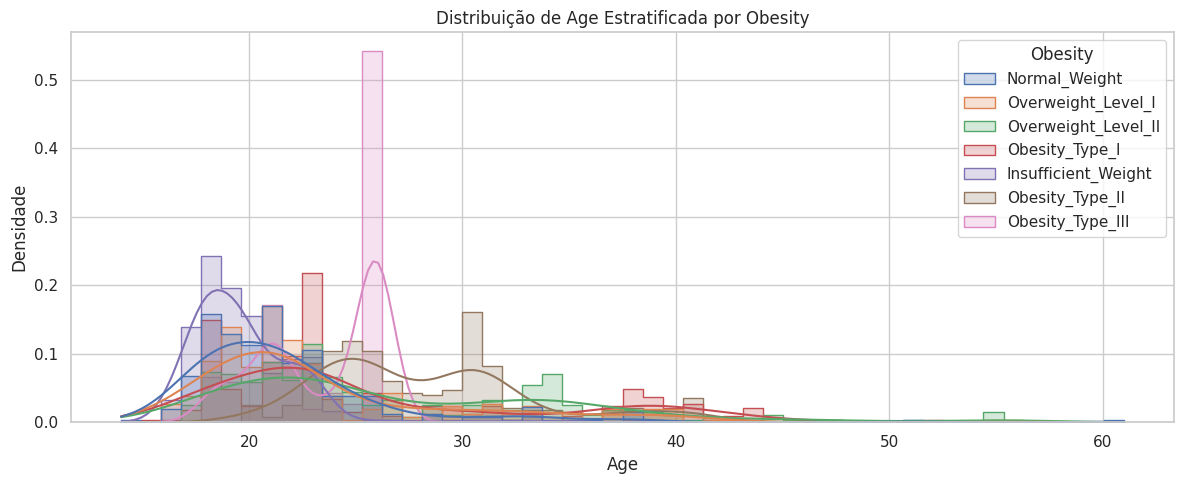

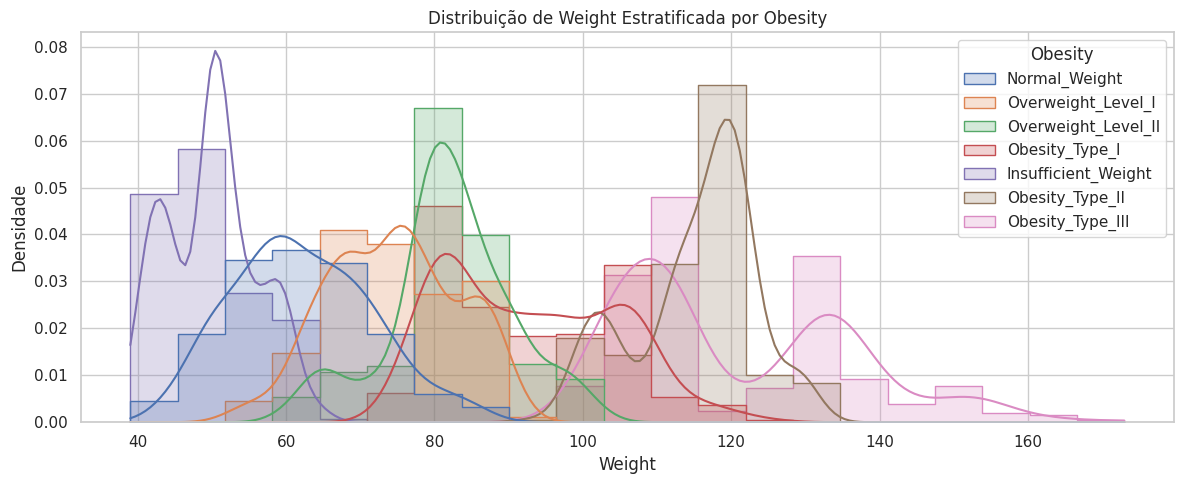

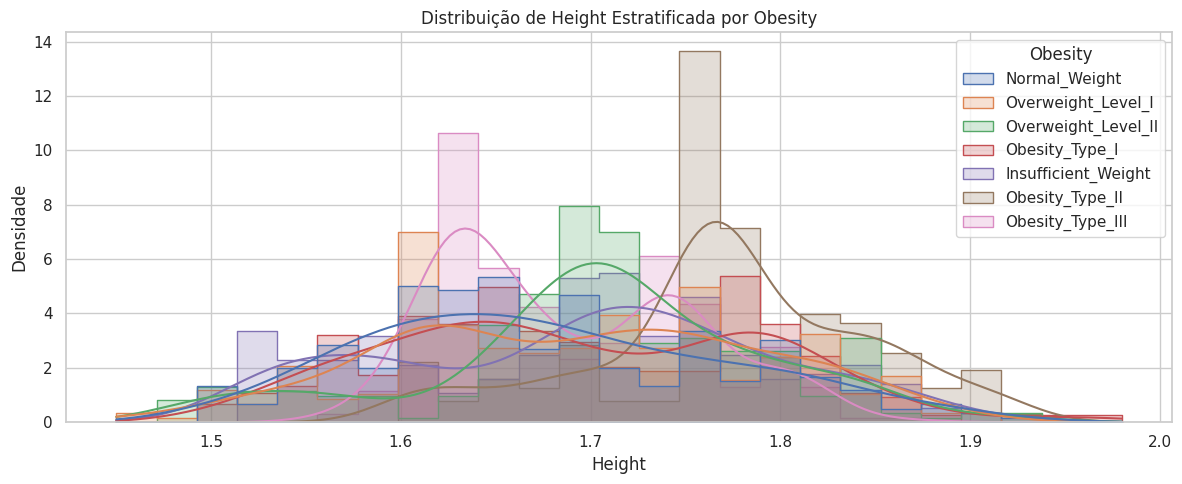

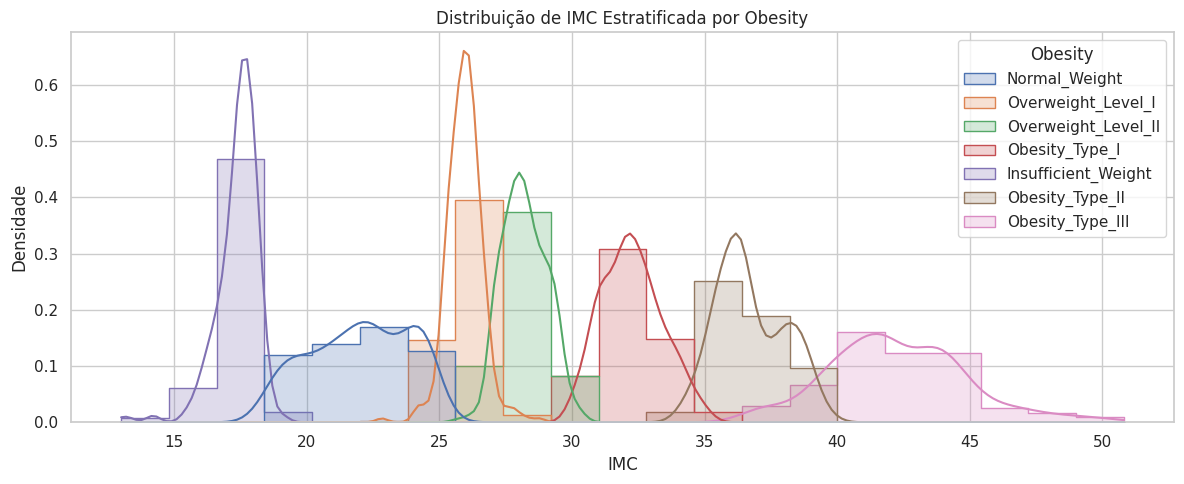

In [12]:
# DISTRIBUIÇÃO ESTRATIFICADA POR NÍVEL DE OBESIDADE

# Objetivo:
# - Comparar a distribuição das variáveis críticas entre diferentes níveis de obesidade
# - Usar histograma + KDE para melhor leitura
# - Permite identificar padrões clínicos relevantes

dist_vars = ['Age', 'Weight', 'Height', 'IMC']
dist_vars = [c for c in dist_vars if c in df.columns]

for col in dist_vars:
    plt.figure(figsize=(12,5))

    # Histograma/KDE estratificado pela classe de obesidade
    sns.histplot(
        data=df,
        x=col,
        hue=target_col,                # separa cores por classe de obesidade
        kde=True,                      # adiciona curva de densidade
        element='step',                # estilo do histograma
        stat='density',                # normaliza as curvas
        common_norm=False              # cada classe normaliza separadamente
    )

    plt.title(f'Distribuição de {col} Estratificada por {target_col}')
    plt.xlabel(col)
    plt.ylabel('Densidade')
    plt.tight_layout()
    plt.show()


In [13]:
# Estatísticas por classe
display(df.groupby('Obesity').agg({'IMC':['mean','median','std'],'Age':'count'}))

IMC                     Age
                          mean  median       std count
Obesity                                               
Insufficient_Weight  17.390861  17.530  0.787046   267
Normal_Weight        22.007908  22.125  1.848359   282
Obesity_Type_I       32.255670  32.200  1.131087   351
Obesity_Type_II      36.723266  36.420  1.290033   297
Obesity_Type_III     42.273920  41.945  2.578889   324
Overweight_Level_I   25.955761  25.950  0.658839   276
Overweight_Level_II  28.215310  28.155  0.827707   290

In [14]:
# Função para detectar outliers usando o método do IQR (Interquartile Range)
def detect_outliers_iqr(series):
    # Q1 = primeiro quartil (25%)
    q1 = series.quantile(0.25)

    # Q3 = terceiro quartil (75%)
    q3 = series.quantile(0.75)

    # IQR = intervalo interquartílico (Q3 - Q1)
    iqr = q3 - q1

    # Retorna limites inferior e superior considerados "não outliers"
    # Valores fora desses limites são considerados outliers
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr


# Seleciona todas as colunas numéricas do DataFrame
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Dicionário para armazenar o relatório de outliers de cada coluna
outlier_report = {}

# Para cada coluna numérica:
for c in numeric_cols:

    # Garante que a coluna tenha valores válidos:
    if df[c].dropna().shape[0] > 0:

        # Calcula limites inferior e superior de outliers via IQR:
        lo, hi = detect_outliers_iqr(df[c].dropna())

        # Armazena no relatório:
        # - os limites calculados
        # - quantos valores estão abaixo do limite inferior
        # - quantos valores estão acima do limite superior
        outlier_report[c] = {
            'lower': lo,
            'upper': hi,
            'n_below': int((df[c] < lo).sum()),
            'n_above': int((df[c] > hi).sum())
        }

# Exibe o relatório em formato de tabela (um resultado por linha)
pd.DataFrame(outlier_report).T


,lower,upper,n_below,n_above
Age,10.789844,35.126094,0.0,167.0
Height,1.421209,1.978461,0.0,1.0
Weight,2.976140,171.039767,0.0,1.0
FCVC,0.500000,4.500000,0.0,0.0
NCP,3.000000,3.000000,472.0,149.0
CH2O,2.000000,2.000000,478.0,502.0
FAF,-3.000000,5.000000,0.0,0.0
TUE,-1.500000,2.500000,0.0,0.0
IMC,6.782500,53.682500,0.0,0.0



 ## 6. Preparação da Pipeline — transformadores personalizados



In [15]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop=None):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        if self.cols_to_drop:
            Xc = Xc.drop(columns=self.cols_to_drop, errors='ignore')
        return Xc


class ImcCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, weight_col='Weight', height_col='Height', imc_col='IMC'):
        self.weight_col = weight_col
        self.height_col = height_col
        self.imc_col = imc_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        if self.weight_col in Xc.columns and self.height_col in Xc.columns:
            Xc[self.imc_col] = Xc[self.weight_col] / (Xc[self.height_col] ** 2)
            Xc[self.imc_col] = Xc[self.imc_col].round(2)
        return Xc


## 7. Engenharia de features e definição de colunas

In [16]:
# Seleciona as colunas numéricas principais usadas no modelo, mas apenas se elas existirem no DataFrame.
num_cols = [c for c in ['Age', 'Height', 'Weight', 'IMC'] if c in df.columns]
# Seleciona as colunas ordinais (variáveis categóricas com ordem), novamente garantindo que existam no DataFrame.
ord_cols = [c for c in ['FCVC','NCP','FAF','CH2O','TUE'] if c in df.columns]
# Seleciona todas as colunas categóricas nominais (dtype 'object'), exceto a coluna target (para evitar que ela seja tratada como input do modelo).
cat_cols = [
    c for c in df.columns
    if df[c].dtype == 'object' and c != target_col
]
# Exibe as listas resultantes para conferência
print('Num:', num_cols)   # Variáveis numéricas
print('Ord:', ord_cols)   # Variáveis ordinais
print('Cat:', cat_cols)   # Variáveis categóricas nominais


Num: ['Age', 'Height', 'Weight', 'IMC']
Ord: ['FCVC', 'NCP', 'FAF', 'CH2O', 'TUE']
Cat: ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


## 8. Pré-processador (imputers, encoders, scaler)

In [17]:
num_pipe = Pipeline([('scaler', MinMaxScaler())])
ord_pipe = Pipeline([('ord', OrdinalEncoder())])
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('ord', ord_pipe, ord_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')


### Estratégia de Pré-processamento

As variáveis numéricas foram padronizadas para garantir que algoritmos sensíveis à escala não fossem impactados por diferenças de magnitude entre os atributos.

As variáveis categóricas foram transformadas por meio de One-Hot Encoding, permitindo que modelos baseados em árvores e algoritmos lineares interpretassem corretamente essas informações.

Todo o processo foi encapsulado em um Pipeline, assegurando reprodutibilidade e prevenindo vazamento de dados entre treino e teste.

## 9. Preparar X, y e split treino/teste (com stratify)

In [18]:
from sklearn.preprocessing import LabelEncoder
X = df.drop(columns=[target_col])
y = df[target_col].copy()
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('Classes:', list(le.classes_))

Train: (1669, 17) Test: (418, 17)
Classes: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']


Testar e registrar explicitamente o
desempenho com múltiplos modelos
(ex: SVM, KNN, Regressão Logística)
para justificar a escolha final do
modelo.

## 10. Balanceamento com SMOTE — aplicar somente no treino

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Exemplo: se classes estiverem desbalanceadas
print('Distribuição treino:', Counter(y_train))
# aplicar SMOTE apenas se necessário
apply_smote = False
if apply_smote:
    # primeiro transformar X_train usando preprocessor para arrays
    X_train_proc = preprocessor.fit_transform(X_train)
    sm = SMOTE(random_state=RANDOM_STATE)
    X_res, y_res = sm.fit_resample(X_train_proc, y_train)
    print('After SMOTE:', pd.Series(y_res).value_counts())
# NOTA: ao usar SMOTE, a persistência do pipeline precisa salvar os encoders separadamente

Distribuição treino: Counter({np.int64(2): 281, np.int64(4): 259, np.int64(3): 237, np.int64(6): 232, np.int64(1): 225, np.int64(5): 221, np.int64(0): 214})


## 11. Comparativo rápido de modelos (RandomForest; XGBoost, Logistic, SVM, KNN)

In [20]:
# pipeline com preprocessor + classifier
pipe_rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))# Usei o RANDON STATE DA PROF
])
pipe_xgb = Pipeline([
    ('preproc', preprocessor),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE)) # XGBoost expects numerical labels
])

# grids
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]}

param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.1]}

# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearch
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv, scoring='accuracy', n_jobs=-1)

print('Treinando RandomForest...')
gs_rf.fit(X_train, y_train) # RandomForest can handle string labels
print('Best RF:', gs_rf.best_score_, gs_rf.best_params_)

print('Treinando XGBoost...')
gs_xgb.fit(X_train, y_train) # Pass encoded labels to XGBoost
print('Best XGB:', gs_xgb.best_score_, gs_xgb.best_params_)

Treinando RandomForest...
Best RF: 0.9766341191490893 {'clf__max_depth': None, 'clf__n_estimators': 200}
Treinando XGBoost...
Best XGB: 0.9814209418999837 {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200}


In [21]:
# PIPELINES COM RANDOM FOREST, XGBOOST, LOGISTIC, SVM E KNN

# Pipeline Random Forest
pipe_rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Pipeline XGBoost
pipe_xgb = Pipeline([
    ('preproc', preprocessor),
    ('clf', XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    ))
])

# Pipeline Logistic Regression
pipe_log = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Pipeline SVM
pipe_svm = Pipeline([
    ('preproc', preprocessor),
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])

# Pipeline KNN
pipe_knn = Pipeline([
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier())
])

# GRIDSEARCH PARA CADA MODELO

# Random Forest grids
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

# XGBoost grids
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.1]
}

# Logistic Regression grids (opcional)
param_grid_log = {
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2']
}

# SVM grids (custo x gamma)
param_grid_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['rbf'],
    'clf__gamma': ['scale', 'auto']
}

# KNN grids
param_grid_knn = {
    'clf__n_neighbors': [5, 11, 21],
    'clf__weights': ['uniform', 'distance']
}

# CROSS-VALIDATION
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GRIDSEARCH EXECUTION
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv, scoring='accuracy', n_jobs=-1)
gs_log = GridSearchCV(pipe_log, param_grid_log, cv=cv, scoring='accuracy', n_jobs=-1)
gs_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=cv, scoring='accuracy', n_jobs=-1)

# TREINAMENTO
print("Treinando RandomForest...")
gs_rf.fit(X_train, y_train)
print("Best RF:", gs_rf.best_score_, gs_rf.best_params_)

print("\nTreinando XGBoost...")
gs_xgb.fit(X_train, y_train)  # XGBoost requer labels numéricos
print("Best XGB:", gs_xgb.best_score_, gs_xgb.best_params_)

print("\nTreinando Logistic Regression...")
gs_log.fit(X_train, y_train)
print("Best Logistic:", gs_log.best_score_, gs_log.best_params_)

print("\nTreinando SVM...")
gs_svm.fit(X_train, y_train)
print("Best SVM:", gs_svm.best_score_, gs_svm.best_params_)

print("\nTreinando KNN...")
gs_knn.fit(X_train, y_train)
print("Best KNN:", gs_knn.best_score_, gs_knn.best_params_)

Treinando RandomForest...
Best RF: 0.9766341191490893 {'clf__max_depth': None, 'clf__n_estimators': 200}

Treinando XGBoost...
Best XGB: 0.9814209418999837 {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200}

Treinando Logistic Regression...
Best Logistic: 0.8639855424286562 {'clf__C': 10, 'clf__penalty': 'l2'}

Treinando SVM...
Best SVM: 0.8747603891316466 {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

Treinando KNN...
Best KNN: 0.7753070435705166 {'clf__n_neighbors': 5, 'clf__weights': 'distance'}


## Considerações sobre Métricas em Contexto Clínico

Em aplicações na área da saúde, erros de classificação podem ter impactos distintos. Neste projeto, especial atenção foi dada às métricas de recall por classe, de forma a minimizar falsos negativos em níveis mais elevados de obesidade, onde o risco clínico tende a ser maior.

Essa abordagem reforça o uso do modelo como ferramenta de apoio à decisão, priorizando segurança e confiabilidade.


In [22]:
# TABELA FINAL DE MÉTRICAS POR MODELO

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Best_models somente com modelos treinados:

best_models = {}

if "gs_rf" in globals() and hasattr(gs_rf, "best_estimator_"):
    best_models["RandomForest"] = gs_rf.best_estimator_

if "gs_xgb" in globals() and hasattr(gs_xgb, "best_estimator_"):
    best_models["XGBoost"] = gs_xgb.best_estimator_

if "gs_log" in globals() and hasattr(gs_log, "best_estimator_"):
    best_models["LogisticRegression"] = gs_log.best_estimator_

if "gs_svm" in globals() and hasattr(gs_svm, "best_estimator_"):
    best_models["SVM"] = gs_svm.best_estimator_

if "gs_knn" in globals() and hasattr(gs_knn, "best_estimator_"):
    best_models["KNN"] = gs_knn.best_estimator_

print("Modelos avaliados:", list(best_models.keys()))


# Métricas finais
metrics_results = []

for name, model in best_models.items():
    y_pred_enc = model.predict(X_test)

    metrics_results.append({
        "Modelo": name,
        "Acurácia": accuracy_score(y_test, y_pred_enc),
        "Precisão (macro)": precision_score(y_test, y_pred_enc, average="macro"),
        "Recall (macro)": recall_score(y_test, y_pred_enc, average="macro"),
        "F1 (macro)": f1_score(y_test, y_pred_enc, average="macro")
    })

df_metrics = pd.DataFrame(metrics_results)
df_metrics

Modelos avaliados: ['RandomForest', 'XGBoost', 'LogisticRegression', 'SVM', 'KNN']


,Modelo,Acurácia,Precisão (macro),Recall (macro),F1 (macro)
0,RandomForest,0.980861,0.981546,0.979791,0.980091
1,XGBoost,0.985646,0.985790,0.984717,0.984896
2,LogisticRegression,0.897129,0.892953,0.894728,0.892823
3,SVM,0.885167,0.881074,0.881407,0.880534
4,KNN,0.779904,0.770400,0.769161,0.766019


### Avaliação de Overfitting

A proximidade entre os resultados obtidos na validação cruzada e no conjunto de teste indica que o modelo apresenta boa capacidade de generalização.

Esse comportamento sugere que o alto desempenho não é resultado de overfitting, mas sim da capacidade do modelo em capturar padrões relevantes nos dados.


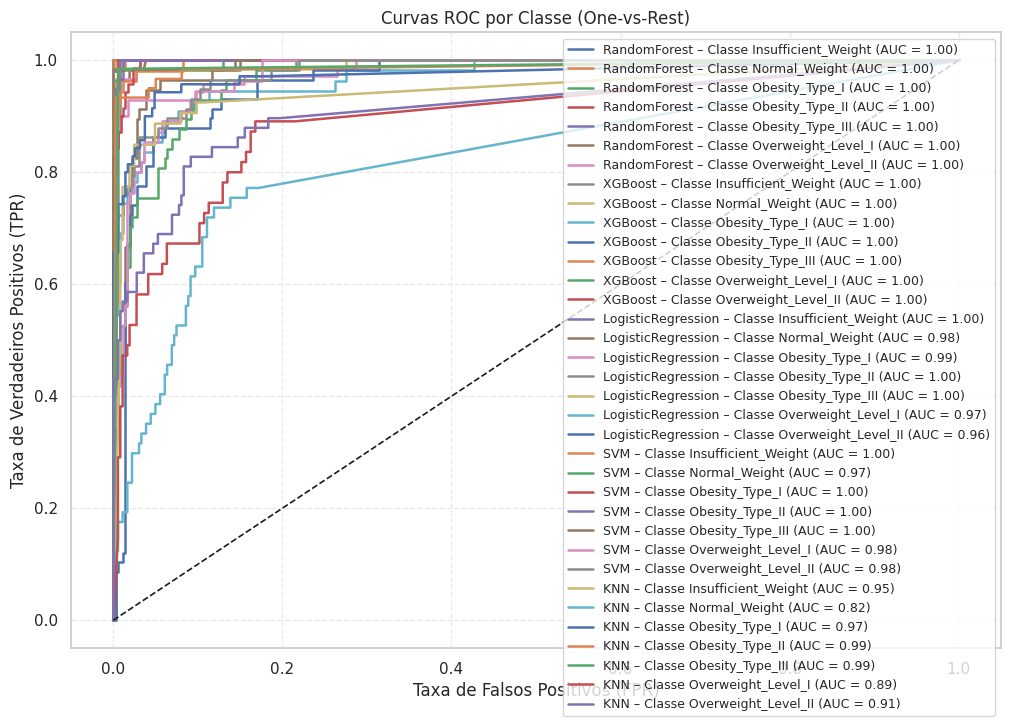

In [23]:

# CURVAS ROC PARA CADA MODELO E CADA CLASSE (One-vs-Rest)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizar classes
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(12, 8))

for name, model in best_models.items():

    # Probabilidades (necessário para ROC)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # fallback para modelos sem probabilidade (ex: SVM com probability=False)
        if hasattr(model, "decision_function"):
            decision = model.decision_function(X_test)

            # Se binário, reshape
            if len(decision.shape) == 1:
                decision = decision.reshape(-1, 1)

            # Normalizar para probabilidade
            y_score = (decision - decision.min()) / (decision.max() - decision.min() + 1e-6)
        else:
            continue  # não é possível gerar ROC

    # Para cada classe
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr,
            tpr,
            lw=1.8,
            label=f"{name} – Classe {le.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})"
        )

# Plot final
plt.plot([0, 1], [0, 1], 'k--', lw=1.2)
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curvas ROC por Classe (One-vs-Rest)")
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

## Escolha dos Modelos

Foram avaliados diferentes algoritmos de Machine Learning com características complementares, incluindo modelos lineares, baseados em distância e baseados em árvores.

A validação cruzada estratificada foi utilizada para preservar a proporção das classes da variável alvo, garantindo uma avaliação mais robusta do desempenho dos modelos em um problema de classificação multiclasse.

## 12. Avaliação no conjunto de teste

Accuracy: 0.9808612440191388
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        53
      Normal_Weight       0.90      1.00      0.95        57
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       1.00      0.93      0.96        55
Overweight_Level_II       0.98      0.97      0.97        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



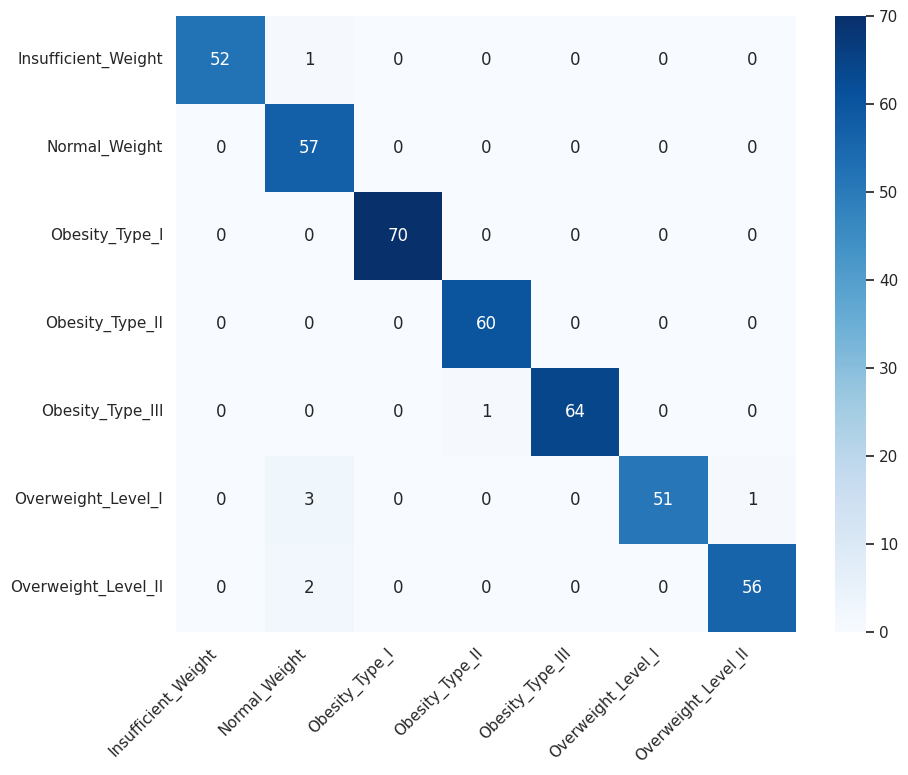

In [24]:
final_pipeline = Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))])
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=list(le.classes_)))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_), cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.show()

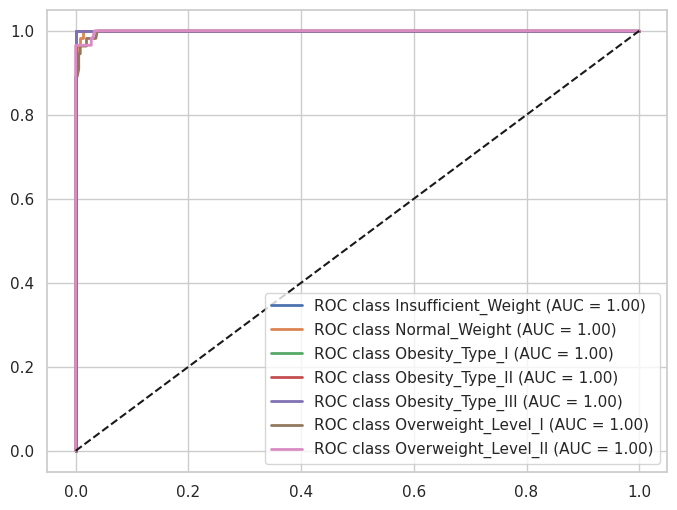

In [25]:
from sklearn.preprocessing import label_binarize
try:
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    y_score = final_pipeline.predict_proba(X_test)
    from sklearn.metrics import roc_curve, auc
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc='lower right')
    plt.show()
except Exception as e:
    print('ROC skipped:', e)

## 13. Explicabilidade: Feature importance e SHAP

### Interpretabilidade e Apoio à Decisão Clínica

A análise de SHAP demonstra que, além de fatores físicos, variáveis comportamentais como atividade física e número de refeições exercem influência significativa nas predições.

Essa interpretabilidade permite que profissionais de saúde compreendam os fatores de risco individuais e direcionem intervenções personalizadas, reforçando o papel do modelo como ferramenta de suporte clínico.


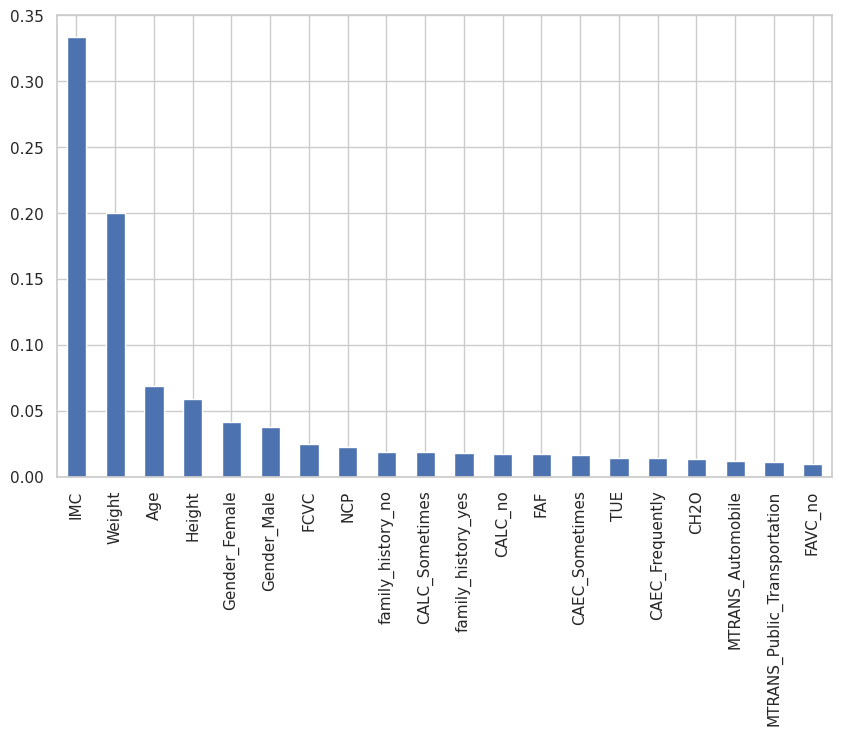

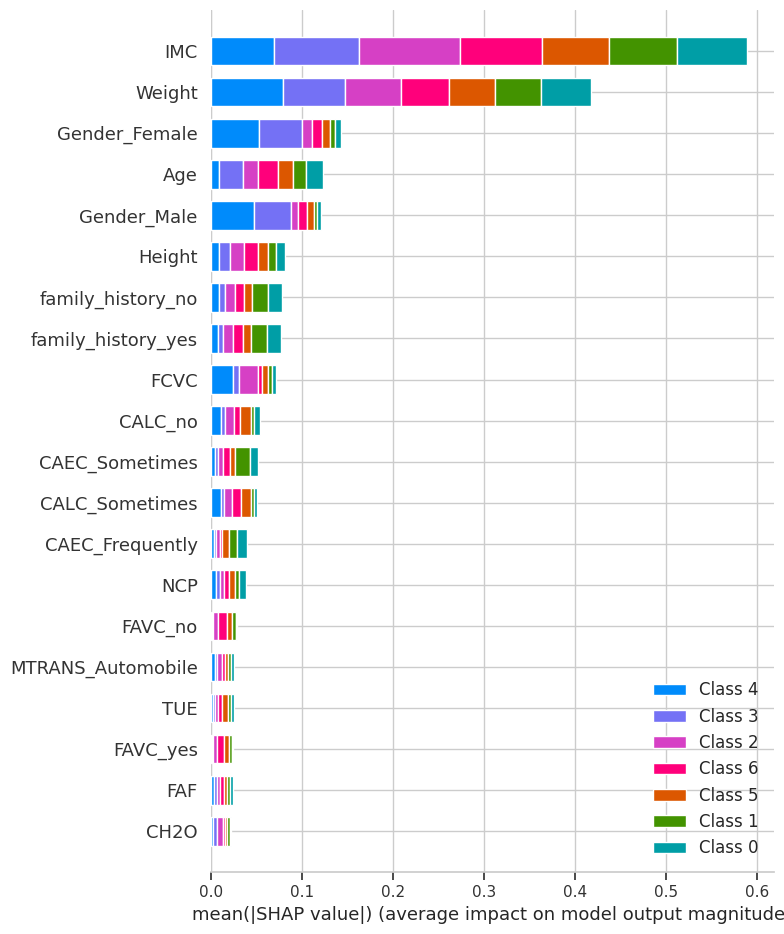

In [26]:
try:
    clf = final_pipeline.named_steps['clf']
    pre = final_pipeline.named_steps['preproc']
    feature_names = []
    feature_names += num_cols
    feature_names += ord_cols
    if 'cat' in pre.named_transformers_:
        ohe = pre.named_transformers_['cat'].named_steps['ohe']
        cat_features = ohe.get_feature_names_out(cat_cols).tolist()
        feature_names += cat_features
    if hasattr(clf, 'feature_importances_'):
        imp = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
        imp.head(20).plot(kind='bar', figsize=(10,6))
        plt.show()
    else:
        print('Sem feature_importances_')
    # SHAP (custoso)
    try:
        explainer = shap.Explainer(clf)
        X_test_proc = pre.transform(X_test)
        if isinstance(X_test_proc, np.ndarray):
            X_df = pd.DataFrame(X_test_proc, columns=feature_names)
        else:
            X_df = X_test_proc
        shap_values = explainer(X_df)
        shap.summary_plot(shap_values, features=X_df)
    except Exception as e:
        print('SHAP skipped:', e)
except Exception as e:
    print('Explicabilidade skip:', e)

## Discussão sobre Variáveis Físicas e Possível Data Leakage

As variáveis Weight (peso) e Height (altura) apresentaram alta importância no modelo, o que é esperado, uma vez que estão diretamente relacionadas ao cálculo do IMC.

Embora essas variáveis tornem o problema mais facilmente separável, o objetivo do modelo é atuar como uma ferramenta de apoio à decisão clínica, considerando informações disponíveis no momento da avaliação do paciente.

## Painel Analítico para Apoio à Gestão em Saúde

Além do sistema preditivo, foi desenvolvido um painel analítico com o objetivo de oferecer uma visão populacional dos dados, permitindo à equipe médica e gestores identificar padrões de risco, fatores predominantes e perfis mais vulneráveis.

Esse painel apoia decisões estratégicas, como campanhas preventivas e direcionamento de recursos.


## 14. Persistir artefatos

In [27]:
preprocessing_code = """
import pandas as pd
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop=None):
        self.cols_to_drop = cols_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        return Xc.drop(columns=self.cols_to_drop, errors='ignore')


class ImcCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, weight_col='Weight', height_col='Height', imc_col='IMC'):
        self.weight_col = weight_col
        self.height_col = height_col
        self.imc_col = imc_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        if self.weight_col in Xc.columns and self.height_col in Xc.columns:
            w = pd.to_numeric(Xc[self.weight_col], errors='coerce')
            h = pd.to_numeric(Xc[self.height_col], errors='coerce')
            Xc[self.imc_col] = (w / (h ** 2)).round(2)
        return Xc


def safe_onehot_encoder(**kwargs):
    if sklearn.__version__ < "1.2":
        return OneHotEncoder(**{**kwargs, 'sparse': False})
    else:
        return OneHotEncoder(**{**kwargs, 'sparse_output': False})
"""
with open("preprocessing.py", "w") as f:
    f.write(preprocessing_code)

print("preprocessing.py criado")

preprocessing.py criado


In [28]:
joblib.dump(final_pipeline, 'model_pipeline.joblib')
pd.Series(X.columns.tolist()).to_csv('col_order.csv', index=False)
print('Salvo: model_pipeline.joblib, col_order.csv')

Salvo: model_pipeline.joblib, col_order.csv


### Persistência dos Artefatos do Modelo

Após a definição do modelo final, tornou-se necessário persistir os artefatos gerados durante o treinamento para possibilitar sua reutilização em ambientes externos ao notebook, como aplicações web.

Foram persistidos:
- O pipeline completo de pré-processamento e modelagem
- A ordem das colunas esperadas pelo modelo

Essa abordagem garante consistência entre o ambiente de treinamento e o ambiente de produção, além de facilitar o deploy da solução preditiva.


## 15. Gerar app Streamlit


In [29]:
streamlit_code = """
import streamlit as st
import joblib
import pandas as pd

from preprocessing import DropCols, ImcCalculator, safe_onehot_encoder

model = joblib.load('model_pipeline.joblib')
col_order = pd.read_csv('col_order.csv', header=None)[0].tolist()

st.title('Sistema Preditivo de Obesidade')

st.write(
    'Esta aplicação utiliza um modelo de Machine Learning para estimar '
    'o nível de obesidade com base em informações demográficas e comportamentais.')


# Mapeamento para interface em português → modelo em inglês
gender_map = {
    "Masculino": "Male",
    "Feminino": "Female"
}

faf_labels = {
    0: "Sedentário",
    1: "Baixa",
    2: "Moderada",
    3: "Alta"
}


# Criar widgets dinamicamente com base no col_order
inputs = {}

for col in col_order:
    if col == 'Age':
        inputs[col] = st.slider("Idade", min_value=1, max_value=120, value=30)
    elif col == 'Height':
        inputs[col] = st.slider("Altura (em metros)", min_value=1.0, max_value=2.5, value=1.70, format='%.2f')
    elif col == 'Weight':
        inputs[col] = st.slider("Peso (em quilos)", min_value=10, max_value=300, value=70)
    elif col == "Gender":
        gender_pt = st.selectbox(
            "Gênero",
            options=list(gender_map.keys())
        )
        inputs[col] = gender_map[gender_pt]
    elif col == "FAF":
        faf_value = st.selectbox(
            "Frequência de Atividade Física",
            options=[0, 1, 2, 3],
            format_func=lambda x: faf_labels[x]
        )
        inputs[col] = faf_value
    else:
        inputs[col] = st.text_input(col)


if st.button("🔍 Realizar Predição"):
    input_df = pd.DataFrame([inputs])
    prediction = model.predict(input_df)[0]

    st.success(f"📊 Nível de Obesidade Previsto: **{prediction}**")

    st.warning(
        "⚠️ Este sistema é uma ferramenta de apoio à decisão clínica "
        "e não substitui a avaliação de um profissional de saúde."
    )

    # Verifica se o modelo permite predict_proba
    try:
        proba = model.predict_proba(input_df)
        st.write(pd.DataFrame(proba, columns=model.classes_))
    except:
        pass
"""

with open("app_streamlit.py", "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("Arquivo app_streamlit.py criado com sucesso")


Arquivo app_streamlit.py criado com sucesso


### Desenvolvimento da Aplicação em Streamlit

Com os artefatos do modelo devidamente persistidos, foi desenvolvida uma aplicação web utilizando Streamlit, permitindo que profissionais de saúde realizem predições de forma interativa.

A aplicação foi projetada com foco em simplicidade, clareza e uso responsável, atuando como ferramenta de apoio à decisão clínica.


 ## 16. Arquivo requirements.txt

In [30]:
requirements = '\n'.join(['python==3.10','pandas==2.1.4','numpy==1.26.4','scikit-learn==1.3.2','joblib==1.3.2','xgboost==2.0.3','imbalanced-learn==0.11.0','streamlit==1.37.1','matplotlib','seaborn','plotly','xgboost','shap'])
open('requirements.txt','w').write(requirements)
print('requirements.txt gerado')

requirements.txt gerado


## 17. Dockerfile

In [31]:
dockerfile = 'FROM python:3.10-slim\nWORKDIR /app\nCOPY . /app\nRUN pip install -r requirements.txt\nEXPOSE 8501\nCMD ["streamlit","run","app_streamlit.py","--server.port=8501","--server.address=0.0.0.0"]'
open('Dockerfile','w').write(dockerfile)
print('Dockerfile gerado')

Dockerfile gerado


In [32]:
from google.colab import files

files.download("app_streamlit.py")
files.download("preprocessing.py")
files.download("model_pipeline.joblib")
files.download("col_order.csv")
files.download("requirements.txt")
files.download("Dockerfile")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
!ls

app_streamlit.py  Dockerfile		 preprocessing.py  requirements.txt
col_order.csv	  model_pipeline.joblib  __pycache__	   sample_data


## Considerações sobre Uso e Ética

Por se tratar de uma aplicação na área da saúde, é fundamental destacar que o sistema desenvolvido não tem caráter diagnóstico. Seu uso deve ser restrito ao apoio à decisão clínica, auxiliando profissionais na identificação de possíveis riscos e na priorização de acompanhamento.

Em um cenário real de produção, aspectos relacionados à segurança da informação, privacidade dos dados e conformidade com a LGPD devem ser rigorosamente observados.


## Conclusão

O projeto apresentou uma solução completa de Data Analytics aplicada à área da saúde, integrando análise exploratória, modelagem preditiva, explicabilidade e deploy.

A utilização de um modelo de alto desempenho, aliada à interpretabilidade e ao uso responsável, demonstra o potencial da solução como ferramenta de apoio à decisão clínica e à promoção de ações preventivas no contexto hospitalar.